In [3]:
import os
import rasterio
import json
import geopandas as gpd
from PIL import Image
from rasterio.mask import mask
import numpy as np
import seaborn as sns
from src.dataset import TreesDataset, TreesDataLoaders
import albumentations as A
from albumentations.pytorch import ToTensorV2
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd

DATASET_FOLDER = "../data/quebec_trees_dataset_2021-09-02/"
TREES_FOLDER = DATASET_FOLDER + "trees/"
ZONE_NUM = 3
ZONE_TIF_FILEPATH_TEMPLATE = (
    DATASET_FOLDER + "2021-09-02/zone{}/2021-09-02-sbl-z{}-rgb-cog.tif"
)
ANNOTATION_FILEPATH_TEMPLATE = DATASET_FOLDER + "Z{}_polygons.gpkg"
TEST_POLYGONS_FILEPATH = DATASET_FOLDER + "inference_zone.gpkg"
TEST_POLYGONS = gpd.read_file(TEST_POLYGONS_FILEPATH)

TRAIN_SPLIT_DIR = DATASET_FOLDER + "train"
TEST_SPLIT_DIR = DATASET_FOLDER + "test"
LABELS: dict[str, int] = {
    "Background": 0,
}

LABELS = {
    0: "Background",
    1: "BEPA",
    2: "ACSA",
    3: "ACRU",
    4: "ABBA",
    5: "ACPE",
    6: "THOC",
    7: "Picea",
    8: "Mort",
    9: "BEAL",
    10: "FAGR",
    11: "Populus",
    12: "TSCA",
    13: "PIST",
    14: "LALA",
}

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.12 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


In [134]:
def count_pixels(file_path = "data/quebec_trees_dataset_2021-09-02/train/cache_0.75.csv") -> dict[str, int]:
    pixel_count = {}
    with open(file_path, 'r') as f:
        df = pd.read_csv(f)
        for mask_dir in df['mask']:
            mask = Image.open(mask_dir)
            pixels = np.array(mask)
            for class_index, class_name in LABELS.items():
                pixel_count[class_name] = pixel_count.get(class_name, 0) + np.sum(pixels == class_index)
    return pixel_count

In [135]:
pixel_count = count_pixels()

In [136]:
#sum of all pixels
total = sum(pixel_count.values())
print(total)
weights = {k: total/v for k, v in pixel_count.items()}
print(weights)
weights = [total/v for k, v in pixel_count.items()]
print(weights)

596639744
{'Background': 3.4530191466532942, 'BEPA': 4.5926189875164365, 'ACSA': 19.36248648391484, 'ACRU': 5.959349019946658, 'ABBA': 38.63779339146058, 'ACPE': 47.750573893092415, 'THOC': 60.89115028641224, 'Picea': 101.5092919220251, 'Mort': 126.451974869821, 'BEAL': 53.14641199657128, 'FAGR': 153.35413320461285, 'Populus': 8.56342995600289, 'TSCA': 521.0181305025927, 'PIST': 20.79967882917113, 'LALA': 10790.121059770323}
[3.4530191466532942, 4.5926189875164365, 19.36248648391484, 5.959349019946658, 38.63779339146058, 47.750573893092415, 60.89115028641224, 101.5092919220251, 126.451974869821, 53.14641199657128, 153.35413320461285, 8.56342995600289, 521.0181305025927, 20.79967882917113, 10790.121059770323]


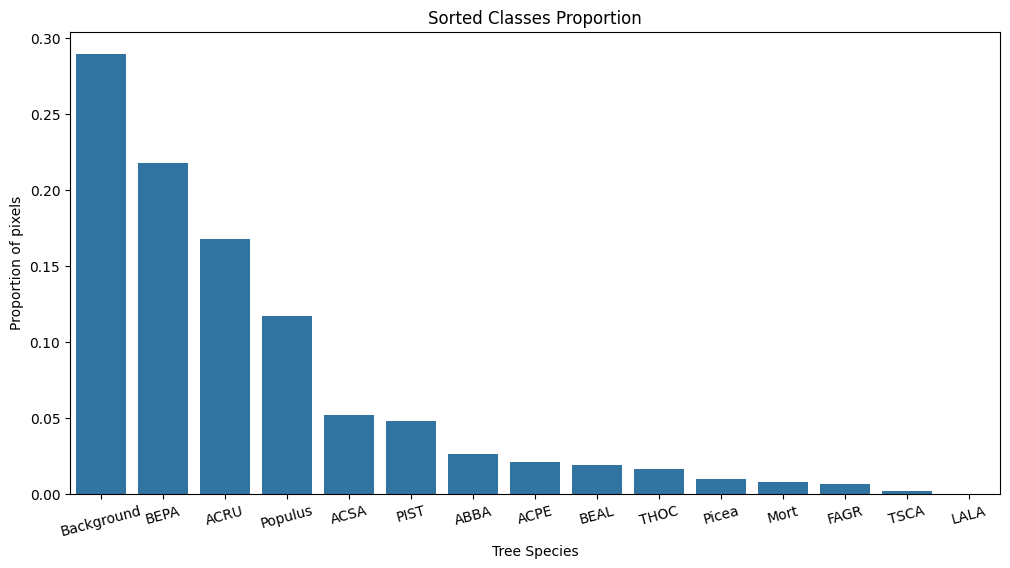

In [137]:
nr_pixels = sum(pixel_count.values())
classes_propotion = {k: v/nr_pixels for k, v in pixel_count.items()}
sorted_classes_propotion = dict(sorted(classes_propotion.items(), key=lambda x: x[1], reverse=True))
#plot the sorted classes propotion using seaborn
plt.figure(figsize=(12, 6))  # Increase figure size for better spacing
sns.barplot(x=list(sorted_classes_propotion.keys()), y=list(sorted_classes_propotion.values()))

# Rotate x-axis labels and increase space between them
plt.xticks(rotation=15, ha='center')

plt.title('Sorted Classes Proportion')
plt.xlabel('Tree Species')
plt.ylabel('Proportion of pixels')
plt.show()


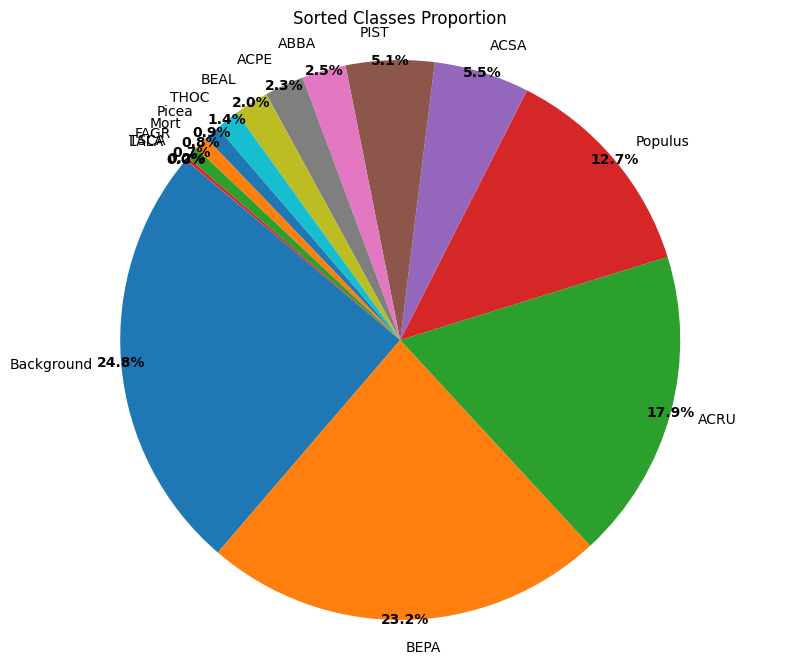

In [51]:
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figure size for better spacing

wedges, texts, autotexts = ax.pie(
    sorted_classes_propotion.values(),
    labels=sorted_classes_propotion.keys(),
    autopct='%1.1f%%',
    startangle=140,
    pctdistance=1  # Push the percentage labels outside
)

# Style the percentage labels
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

plt.title('Sorted Classes Proportion')
plt.show()

15
13
{'Background': 0.2896016377346796, 'BEPA': 0.21774068406679928, 'ACRU': 0.1678035632168681, 'Populus': 0.11677563839930852, 'ACSA': 0.05164625942183295, 'PIST': 0.04807766543959901, 'ABBA': 0.025881395189121026, 'ACPE': 0.020942156679391442, 'BEAL': 0.01881594565715019, 'THOC': 0.016422747727647187, 'Picea': 0.00985131490000103, 'Mort': 0.00790814062832529, 'FAGR': 0.006520854567811024}
[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]


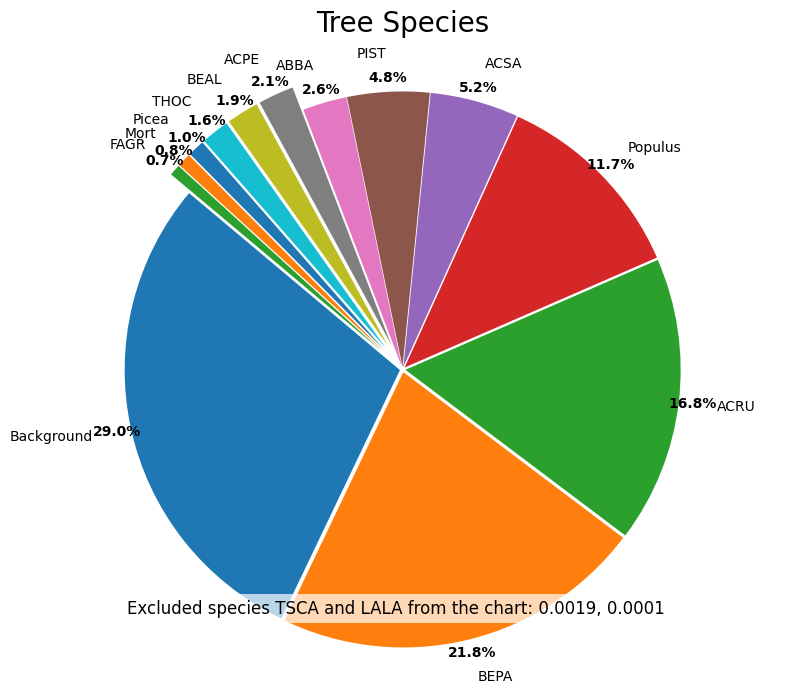

In [162]:
nr_pixels = sum(pixel_count.values())
classes_propotion = {k: v / nr_pixels for k, v in pixel_count.items()}
sorted_classes_propotion = dict(sorted(classes_propotion.items(), key=lambda x: x[1], reverse=True))
#remove key 'TSCA' from the dictionary
print(len(sorted_classes_propotion))
#round sorted_classes_propotion['LALA'] and sorted_classes_propotion['TSCA'] to 3 decimals
lala = sorted_classes_propotion['LALA'].round(4)
tsca = sorted_classes_propotion['TSCA'].round(4)
#do plt.text(-1.5, 1.5, f'Excluded species TSCA and LALA from the chart: {sorted_classes_propotion['LALA']}, {sorted_classes_propotion['TSCA']}', fontsize=12), round the values to 2 decimals

sorted_classes_propotion.pop('LALA')
sorted_classes_propotion.pop('TSCA')
print(len(sorted_classes_propotion))
# Create an explode list to create spaces between the segments
explode = [0.01] * len(sorted_classes_propotion)  # Adjust the explode value as needed
print(sorted_classes_propotion)
for i in range(1,7):
    explode[-i] = 0.1
print(explode)
# Plot the sorted classes proportion using a pie chart
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figure size for better spacing

wedges, texts, autotexts = ax.pie(
    sorted_classes_propotion.values(),
    labels=sorted_classes_propotion.keys(),
    autopct='%1.1f%%',
    startangle=140,
    pctdistance=1.05,  # Push the percentage labels outside
    explode=explode,  # Add the explode parameter to create spaces
    labeldistance = 1.14
)

# Style the percentage labels
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')
# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')
#add padding between the title and the pie chart
plt.title('Tree Species', fontsize= 20, pad=20)
#add a note to the pie chart at the bottom left corner
plt.text(
    -1, -0.9,  # x and y coordinates (normalized to [-1, 1])
    f'Excluded species TSCA and LALA from the chart: {tsca}, {lala}',  # Text to display
    fontsize=12,  # Font size of the note
    ha='left',  # Horizontal alignment
    va='bottom',  # Vertical alignment
    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)  # Background box with slight transparency
)
plt.show()


In [ ]:
TEST_POLYGONS = gpd.read_file(TEST_POLYGONS_FILEPATH)
# view the first few rows of the test polygons
print(TEST_POLYGONS.head())

In [13]:
MAP: dict[str, str] = {
    "Acer": "ACPE",
    "PIGL": "Picea",
    "PIMA": "Picea",
    "PIRU": "Picea",
    "POGR": "Populus",
    "POTR": "Populus",
    "QURU": "BEAL",
    "Feuillus": "ACSA",
    "Conifere": "Picea",
    "FRNI": "BEAL",
    "Betula": "BEAL",
    "PRPE": "ACSA",
    "POBA": "Populus",
    "BEPO": "BEPA",
    "OSVI": "FAGR"
    # "QURU": "Background",
    # "Feuillus": "Background",
    # "Conifere": "Background",
    # "FRNI": "Background",
    # "Betula": "Background",
    # "PRPE": "Background",
    # "POBA": "Background",
    # "BEPO": "Background",
    # "OSVI": "Background",
}

labels_d = {}
for zone in range(1, 4):
    annotations: gpd.GeoDataFrame = gpd.read_file(
                ANNOTATION_FILEPATH_TEMPLATE.format(zone)
            )
    #count the number of trees in each class
    annotations['Label'] = annotations["Label"].replace(MAP)
    count = annotations["Label"].value_counts()
    #modify count each iteration to add the count of trees in each class
    for key, value in count.items():
        if key in labels_d:
            labels_d[key] += value
        else:
            labels_d[key] = value

#print LABELS in descending order using values for sorting
print(dict(sorted(labels_d.items(), key=lambda item: item[1], reverse=True)))
#print sum of all trees
print(sum(labels_d.values()))
#print sum of length of all gpd dataframes
print(sum([len(gpd.read_file(ANNOTATION_FILEPATH_TEMPLATE.format(zone))) for zone in range(1, 4)]))


{'BEPA': 5898, 'ACRU': 5857, 'ABBA': 2895, 'THOC': 1510, 'ACPE': 1223, 'Populus': 1116, 'ACSA': 1115, 'Picea': 1076, 'Mort': 878, 'PIST': 569, 'BEAL': 327, 'FAGR': 225, 'LALA': 185, 'TSCA': 59}
22933
22933


In [ ]:
for zone in range(1, 4):
    annotations: gpd.GeoDataFrame = gpd.read_file(
                ANNOTATION_FILEPATH_TEMPLATE.format(zone)
            )
    #for each row in annotations get the label and the geometry
    for count, row in annotations.iterrows():
        label = row["Label"]
        geometry = row["geometry"]
        #Use the geometry to get the bounds of the polygon
        bounds = geometry.bounds
        #Open the zone tif file
        with rasterio.open(ZONE_TIF_FILEPATH_TEMPLATE.format(zone, zone)) as src:
            zone_tif = src
            zone_bounds = src.bounds
            #Check if the bounds of the polygon is within the bounds of the image
            if (
                bounds[0] >= zone_bounds[0]
                and bounds[1] >= zone_bounds[1]
                and bounds[2] <= zone_bounds[2]
                and bounds[3] <= zone_bounds[3]
            ):
                #If the bounds of the polygon is within the bounds of the image, get the tree image specific to the polygon
                tree_image, tree_transform = mask(
                    zone_tif, [geometry], crop=True
                )
                #Check if the folder TREES_FOLDER + label exists
                if not os.path.exists(TREES_FOLDER + label):
                    #If it does not exist, create the folder
                    os.makedirs(TREES_FOLDER + label)
                #Save the tree image to the folder as a .jpg image
                path = TREES_FOLDER + label + "/" + str(count) + ".jpg"
                Image.fromarray(tree_image[:3].transpose(1, 2, 0), mode='RGB').save(path)

Creating cache: ..\data\quebec_trees_dataset_2021-09-02\train\cache_0.5.csv
Cache created: ..\data\quebec_trees_dataset_2021-09-02\train\cache_0.5.csv
Creating cache: ..\data\quebec_trees_dataset_2021-09-02\test\cache_0.5.csv
Cache created: ..\data\quebec_trees_dataset_2021-09-02\test\cache_0.5.csv
all samples {0: 0.24870015700988735, 1: 0.22695973956152748, 3: 0.1797832432688528, 11: 0.12904918682443833, 2: 0.05571188199796877, 13: 0.0556778121949133, 4: 0.023751433429400032, 5: 0.022210721224558482, 9: 0.018434734316416915, 6: 0.01385952905073177, 7: 0.008937845010416851, 8: 0.007734157502553089, 10: 0.007254453309617941, 12: 0.0018465916186567333, 14: 8.851368006011896e-05}


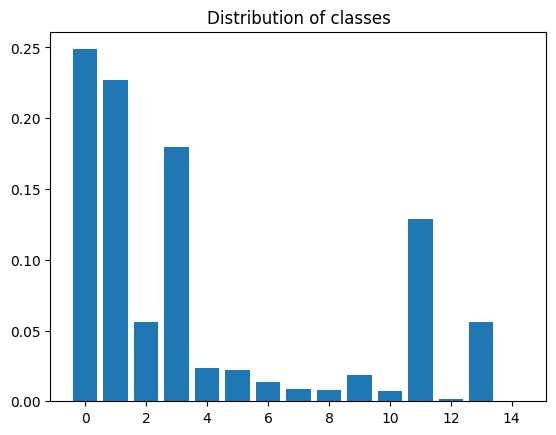

In [2]:
transforms = A.Compose(
        [
            A.Resize(504, 504),
            A.Normalize(),
            ToTensorV2(),
        ]
    )

augmentations = A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.Transpose(p=0.5),
        ]
    )

data_loader = TreesDataLoaders(Path(DATASET_FOLDER), 64, 0, transforms, augmentations)
unique_b = {}

for _, (x,y) in enumerate(data_loader.train):
        #count the unique values in y
        unique, counts = np.unique(y.numpy(), return_counts=True)
        #for every unique value create an entry in unique_b if it does not exist, otherwise add the count to the existing count
        for i in range(len(unique)):
            if unique[i] in unique_b:
                unique_b[unique[i]] += counts[i]
            else:
                unique_b[unique[i]] = counts[i]
        #print the unique values and their counts sorted by counts in descending order

#sum all the counts of the unique values
sum_all = sum(unique_b.values())
#divide each count by the sum of all counts to get the percentage of each class
for key in unique_b:
    unique_b[key] = unique_b[key]/sum_all
print("all samples", dict(sorted(unique_b.items(), key=lambda item: item[1], reverse=True)))
#plot the distribution of the classes
plt.bar(unique_b.keys(), unique_b.values())
plt.title("Distribution of classes")
plt.show()

In [3]:
cache_csv = TRAIN_SPLIT_DIR + "/cache_0.5.csv"
df = pd.read_csv(cache_csv)
#for each file name in cache_csv["mask"] open that file
tree_in_image = {}
for mask_file in df["mask"]:
    mask = Image.open(mask_file)
    mask = np.array(mask)
    # #count the unique values in the mask
    unique, counts = np.unique(mask, return_counts=True)
    counts = counts * 1 / np.sum(counts)
    # add unique values as keys if they do not exsist in tree_in_image, otherwise add the file name to the list of file names and also the count
    for i in range(len(unique)):
        if unique[i] in tree_in_image:
            tree_in_image[int(unique[i])]["files"].append(mask_file)
        else:
            tree_in_image[int(unique[i])] = {"files": [mask_file]}
#save tree_in_image to a csv file

    # #for each unique value in the mask, print the class and the count
    # for i in range(len(unique)):
    #     print(LABELS[unique[i]], counts[i])
    # #print the sum of all counts
    # print("sum", sum(counts))
    # #print the unique values and their counts sorted by counts in descending order
    # print(dict(sorted(zip(unique, counts), key=lambda item: item[1], reverse=True)))
    # #plot the distribution of the classes
    # plt.bar(unique, counts)
    # plt.title("Distribution of classes")
    # plt.show()

In [20]:
BATCH_SIZE = 60
num_samples_per_class = BATCH_SIZE // LABELS.__len__()
#for each class in LABELS, get the files of the class and the count of files
count = 0
files_ = []
for _class, _ in LABELS.items():
    files = tree_in_image[_class]["files"]
    files_.extend([i[1] for i in files])
    number_of_images = len(files)
    print(number_of_images)
print()
#remove duplicates in files_ list
print(len(files_))
fsawa = set(files_)
#print length of files_ list
print(len(fsawa))
        #if the number of images is less than the number of samples per class, raise an error
    # if number_of_images < num_samples_per_class:
    #     print(f"Number of images for class {tree} is less than {num_samples_per_class}, {number_of_images}")
    # indices = np.random.choice(number_of_images, num_samples_per_class, replace=False)
    # print(indices)


1724
547
1672
656
522
250
162
562
193
137
883
50
440

7798
1


65


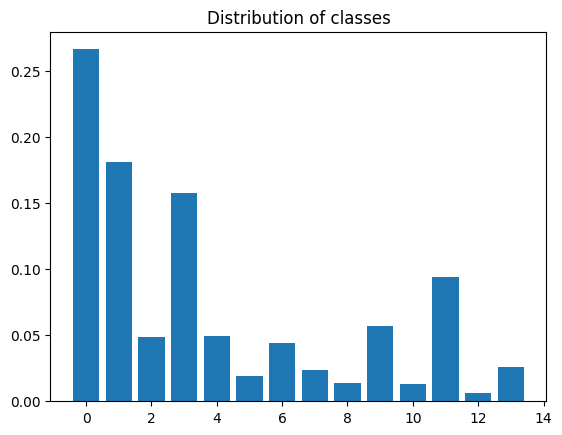

In [23]:
BATCH_SIZE = 65
num_samples_per_class = BATCH_SIZE // LABELS.__len__()
#for each class in LABELS, get the files of the class and the count of files
indices_ = np.array([])
label_indices = {}
for _class, _ in LABELS.items():
    #if any index in indices is 
    files = tree_in_image[_class]["files"]
    number_of_images = len(files)
    if number_of_images > num_samples_per_class:
        indices = np.random.choice(number_of_images, num_samples_per_class, replace=False)
    else:
        get_all_nr_times = num_samples_per_class // number_of_images
        indices = np.arange(number_of_images)
        indices = np.tile(indices, get_all_nr_times)
        indices = np.append(indices, np.random.choice(number_of_images, num_samples_per_class % number_of_images, replace=False))
    label_indices[_class] = indices

file_names = {}
_files = []
#for each label in label_indices, get the file names in tree_in_image
for label, indices in label_indices.items():
    files = tree_in_image[label]["files"]
    #for each index in indices, get the file name and add it to indices_
    for index in indices:
        if label in file_names:
            file_names[label].append(files[index])
            _files.append(files[index])
        else:
            file_names[label] = [files[index]]
            _files.append(files[index])
print(len(set(_files)))

unique_batch = {}
for _, mask_files in file_names.items():
    for mask_file in mask_files:
        mask = Image.open(mask_file)
        mask = np.array(mask)
        # #count the unique values in the mask
        unique, counts = np.unique(mask, return_counts=True)
        # add unique values as keys if they do not exist and add the count to the existing count
        for i in range(len(unique)):
            if unique[i] in unique_batch:
                unique_batch[unique[i]] += counts[i]
            else:
                unique_batch[unique[i]] = counts[i]
#sum all the counts of the unique values
sum_all = sum(unique_batch.values())
#divide each count by the sum of all counts to get the percentage of each class
for key in unique_batch:
    unique_batch[key] = unique_batch[key]/sum_all
#plot the distribution of the classes
plt.bar(unique_batch.keys(), unique_batch.values())
plt.title("Distribution of classes")
plt.show()




In [18]:
unique_batch = {}
for _, mask_files in file_names.items():
    for mask_file in mask_files:
        mask = Image.open(mask_file)
        mask = np.array(mask)
        # #count the unique values in the mask
        unique, counts = np.unique(mask, return_counts=True)
        # add unique values as keys if they do not exist and add the count to the existing count
        for i in range(len(unique)):
            if LABELS[unique[i]] in unique_batch:
                unique_batch[LABELS[unique[i]]] += counts[i]
            else:
                unique_batch[LABELS[unique[i]]] = counts[i]
#sum all the counts of the unique values
sum_all = sum(unique_batch.values())
#divide each count by the sum of all counts to get the percentage of each class
for key in unique_batch:
    unique_batch[key] = unique_batch[key]/sum_all
#plot the distribution of the classes
plt.bar(unique_batch.keys(), unique_batch.values())
plt.title("Distribution of classes")
plt.show()

KeyError: 0

In [4]:
with open('tree_in_image.json', 'w') as f:
    json.dump(tree_in_image, f)

In [5]:
tree_in_image = {}
with open('tree_in_image.json', 'r') as f:
    #read keys as integers
    tree_in_image = json.load(f)
    tree_in_image = {int(k): v for k, v in tree_in_image.items()}

Creating zones' images

src.shape: (41984, 39935)
data_overview[0].shape: (2659, 2662)
src.shape: (32699, 38911)
data_overview[0].shape: (2659, 2662)
src.shape: (26596, 26624)
data_overview[0].shape: (2659, 2662)


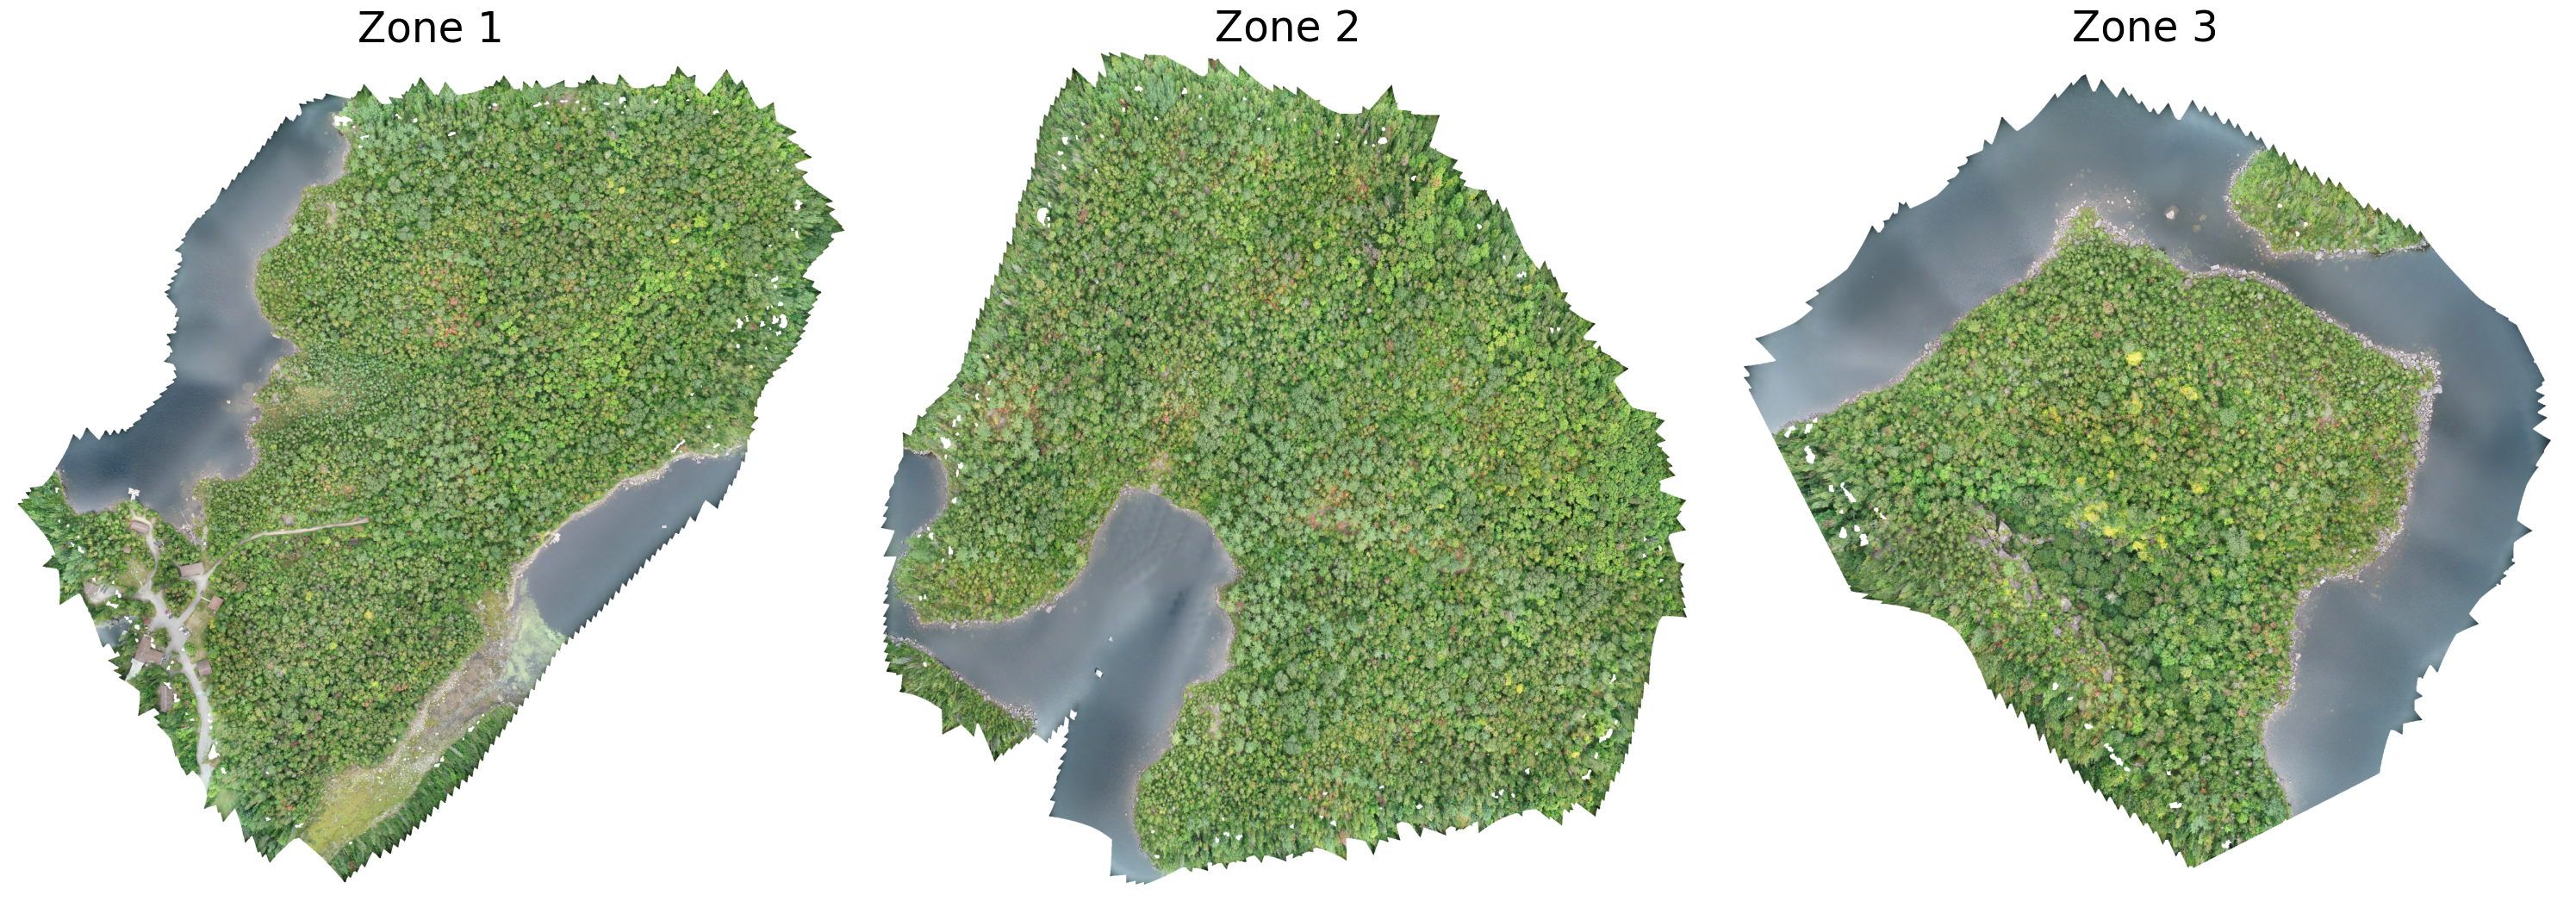

In [34]:
images = []
for zone in range(1, 4):
    with rasterio.open(ZONE_TIF_FILEPATH_TEMPLATE.format(zone, zone)) as src:
        # Read data with reduced resolution
        print(f"src.shape: {src.shape}")
        data_overview = src.read(out_shape=(src.count, 2659, 2662))
        print(f"data_overview[0].shape: {data_overview[0].shape}")
        for i in range(3):
            data_overview[i][data_overview[i] == 0] = 255
        images.append(np.dstack((data_overview[0], data_overview[1], data_overview[2])))
for id, image in enumerate(images):
    image_directory = '../poster'
    if not os.path.exists(image_directory):
        os.makedirs(image_directory)
    image_path = os.path.join(image_directory, f"zone{id+1}.jpg")
    Image.fromarray(image, mode='RGB').save(image_path)
num_images = len(images)
fig, axes = plt.subplots(1, num_images, figsize=(30, 15))
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.axis('off')  # Hide the axis
    ax.set_title(f'Zone {i + 1}', fontsize=35) 

plt.tight_layout() 
plt.show()

Create a summary table for VOC Dataset

In [85]:
def loss_name(file_name):
    loss_name = ''
    if 'cross_entropy' in file_name:
        if 'weighted' in file_name:
            loss_name = 'WCE'
        else:
            loss_name = 'CE'
    elif 'tversky' in file_name:
        loss_name = 'FT'
    else:
        loss_name = 'F'
    
    return loss_name

def use_batch_norm(file_name):
    if file_name == 'voc-cross_entropy.csv' or file_name == 'voc-cross_entropy-weighted_loss.csv':
        return False
    return True
    

df = pd.DataFrame(columns=['Loss',	'BN', 'Pixel accuracy', 'mIoU', 'f1'])
for file in os.listdir('results'):
    if 'voc' in file:
        with open('results/' + file, 'r') as f:
            pd_file = pd.read_csv(f)
            best_row = pd_file.loc[pd_file['mIoU'].idxmax()]
            best_row = best_row.drop(['epoch', 'train_loss', 'train_accuracy', 'val_loss'])
            best_row = best_row.rename({'val_accuracy': 'Pixel accuracy'})
            best_row = best_row.to_frame().T  # Convert Series to DataFrame and transpose'
            best_row.insert(0, 'Loss', loss_name(file))
            best_row.insert(1, 'BN', use_batch_norm(file))
            df = pd.concat([df, best_row], ignore_index=True)
#remove the row with index 1
df = df.drop(1)
df = df.sort_values(by='mIoU', ascending=True).reset_index(drop=True)
#convert df to latex table
df

C:\Users\Settings\AppData\Local\Temp\ipykernel_18308\833444073.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, best_row], ignore_index=True)


Loss     BN  Pixel accuracy      mIoU        f1
0    F   True        0.702855  0.023389  0.037229
1   CE  False        0.915070  0.516768  0.593185
2   FT   True        0.911580  0.738153  0.823702
3  WCE  False        0.605408  0.822062  0.891287
4  WCE   True        0.796195  0.902669  0.944027

Create plots for the VOC Dataset

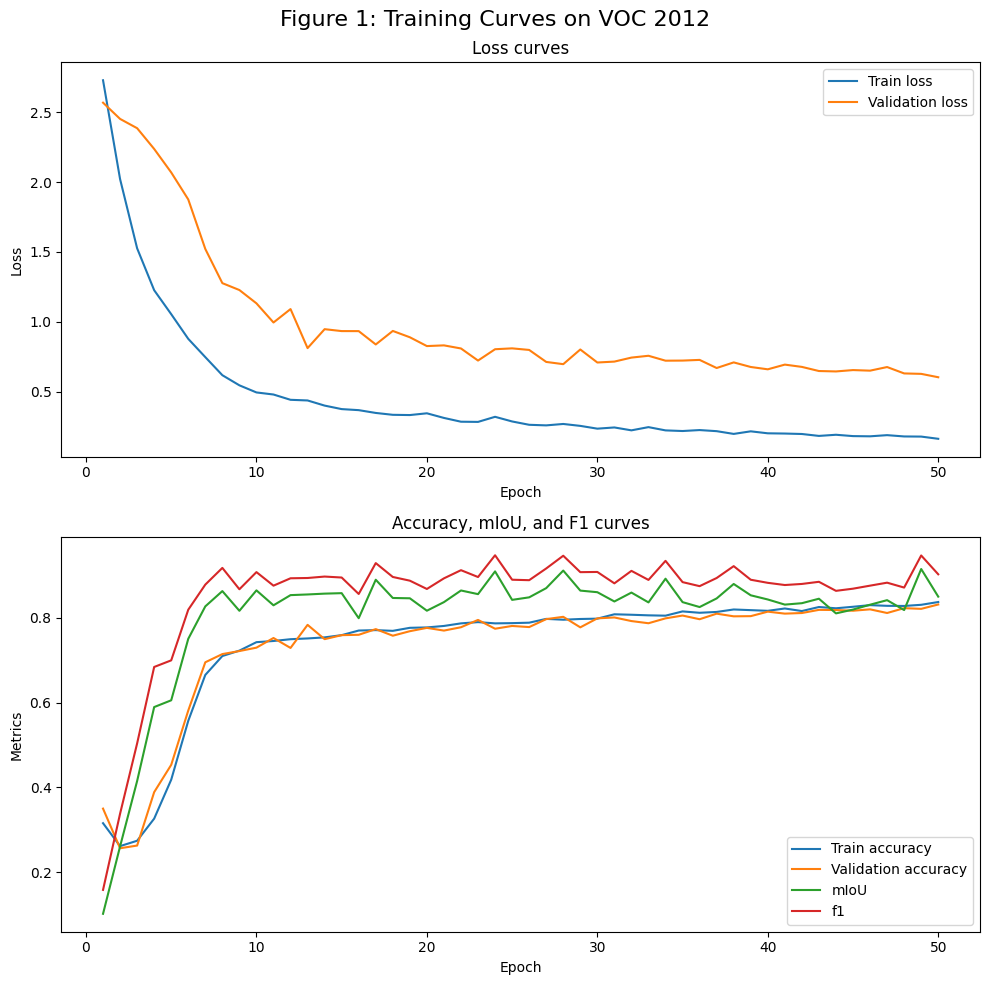

In [120]:
# Read the CSV file
with open('results/voc-cross_entropy-weighted_loss-batch_norm.csv', 'r') as f:
    pd_file = pd.read_csv(f)

# Create a figure and two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot the loss curves on the first subplot
ax1.plot(pd_file['epoch'], pd_file['train_loss'], label='Train loss')
ax1.plot(pd_file['epoch'], pd_file['val_loss'], label='Validation loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Loss curves')

# Plot the accuracy, mIoU, and f1 curves on the second subplot
ax2.plot(pd_file['epoch'], pd_file['train_accuracy'], label='Train accuracy')
ax2.plot(pd_file['epoch'], pd_file['val_accuracy'], label='Validation accuracy')
ax2.plot(pd_file['epoch'], pd_file['mIoU'], label='mIoU')
ax2.plot(pd_file['epoch'], pd_file['f1'], label='f1')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Metrics')
ax2.legend()
ax2.set_title('Accuracy, mIoU, and F1 curves')

#set the plot title to 'Training Curves' and adjust layout to prevent overlap
fig.suptitle('Figure 1: Training Curves on VOC 2012', fontsize=16)
# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure as an image
plt.savefig('training_curves.png', bbox_inches='tight')

# Display the plots
plt.show()


Create a summary table for Tree Dataset

In [90]:
def model_name(file_name):
    if 'deeplab' in file_name:
        return 'DeepLabV3'
    return 'DINOv2'

def batch_size(file_name):
    #use regex to check if there'is a b followed by on of the numbers 16, 32, 64
    batch_size = 16
    if 'b32' in file_name:
        batch_size = 32
    if 'b64' in file_name:
        batch_size = 64
    return batch_size

def loss_name(file_name):
    loss_name = 'CE'
    if 'cross_entropy' and 'weighted' in file_name:
        loss_name = 'WCE'
    elif 'tversky' in file_name:
        loss_name = 'FT'
    else:
        loss_name = 'F'
    
    return loss_name

def use_batch_norm(file_name):
    if file_name == 'trees-cross_entropy.csv' or file_name == 'trees-cross_entropy-weighted_loss.csv':
        return False
    return True

df = pd.DataFrame(columns=['Model', 'Loss',	'Batch size', 'BN', 'Pixel accuracy', 'mIoU', 'f1'])
file_miou = {}
for file in os.listdir('results'):
    if 'trees' in file and 'txt' not in file:
        with open('results/' + file, 'r') as f:
            pd_file = pd.read_csv(f)
            best_row = pd_file.loc[pd_file['mIoU'].idxmax()]
            file_miou[file] = best_row['mIoU']
            best_row = best_row.drop(['epoch', 'train_loss', 'train_accuracy', 'val_loss'])
            best_row = best_row.rename({'val_accuracy': 'Pixel accuracy'})
            best_row = best_row.to_frame().T  # Convert Series to DataFrame and transpose'
            best_row.insert(0, 'Model', model_name(file))
            best_row.insert(1, 'Loss', loss_name(file))
            best_row.insert(2, 'Batch size', batch_size(file))
            best_row.insert(3, 'BN', use_batch_norm(file))
            df = pd.concat([df, best_row], ignore_index=True)
df = df.sort_values(by='mIoU', ascending=True).reset_index(drop=True)

df

C:\Users\Settings\AppData\Local\Temp\ipykernel_18308\4209695971.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, best_row], ignore_index=True)


Model Loss Batch size     BN  Pixel accuracy      mIoU        f1
0      DINOv2    F         16   True        0.434168  0.079736  0.120501
1      DINOv2    F         16  False        0.561715  0.171431  0.222180
2      DINOv2  WCE         16  False        0.380656  0.195109  0.286973
3      DINOv2  WCE         16   True        0.427140  0.222534  0.315998
4   DeepLabV3    F         64   True        0.354680  0.237758  0.341184
5      DINOv2    F         64   True        0.374180  0.239883  0.354978
6   DeepLabV3    F         32   True        0.380095  0.248333  0.373395
7      DINOv2   FT         16   True        0.531549  0.267312  0.377328
8      DINOv2    F         32   True        0.398545  0.274302  0.385616
9      DINOv2  WCE         16   True        0.413477  0.301006  0.417084
10  DeepLabV3    F         16   True        0.419510  0.357973  0.481595

Create plots for the Tree Dataset

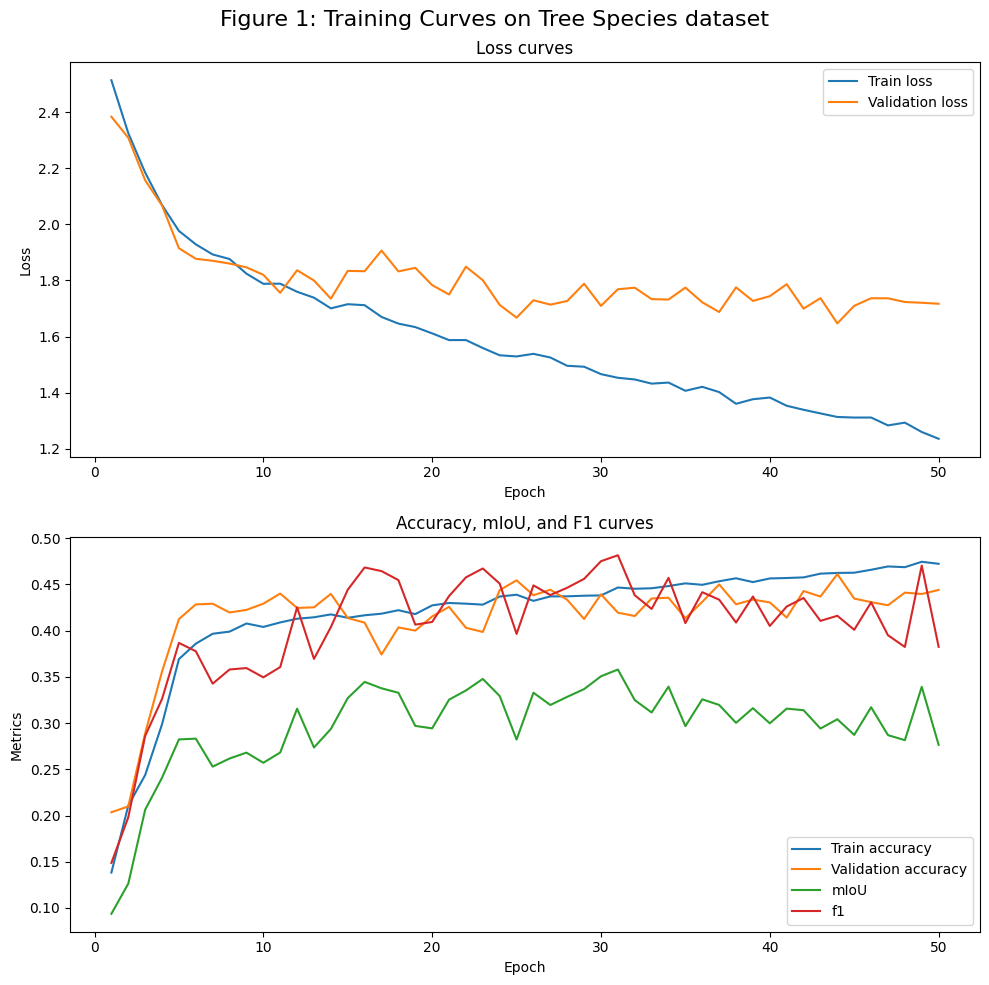

In [122]:
# Read the CSV file with highest mIoU
file_name = max(file_miou, key=file_miou.get)
# Read the CSV file
with open(f'results/{file_name}', 'r') as f:
    pd_file = pd.read_csv(f)

# Create a figure and two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot the loss curves on the first subplot
ax1.plot(pd_file['epoch'], pd_file['train_loss'], label='Train loss')
ax1.plot(pd_file['epoch'], pd_file['val_loss'], label='Validation loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Loss curves')

# Plot the accuracy, mIoU, and f1 curves on the second subplot
ax2.plot(pd_file['epoch'], pd_file['train_accuracy'], label='Train accuracy')
ax2.plot(pd_file['epoch'], pd_file['val_accuracy'], label='Validation accuracy')
ax2.plot(pd_file['epoch'], pd_file['mIoU'], label='mIoU')
ax2.plot(pd_file['epoch'], pd_file['f1'], label='f1')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Metrics')
ax2.legend()
ax2.set_title('Accuracy, mIoU, and F1 curves')

#set the plot title to 'Training Curves' and adjust layout to prevent overlap
fig.suptitle('Figure 1: Training Curves on Tree Species dataset', fontsize=16)
# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure as an image
plt.savefig('training_curves.png', bbox_inches='tight')

# Display the plots
plt.show()


In [114]:

# Define the path to your .txt file
file_path = 'results/trees-cross_entropy-weighted_loss-batch_norm-skip_tconv_batch_norm.txt'
pd_trees_test = pd.DataFrame(columns=['Model','Loss', 'Pixel Accuracy', 'mIoU', 'f1'])
# Read the content of the file
for file in os.listdir('results'):
    if 'trees' in file and 'txt' in file:
        with open('results/' + file, 'r') as f:
            first_line = f.read()
        #separate by the first 4 commas and get the first 4 values
        first_line = first_line.split(',')[0:4]
        #remove non-numeric characters from the first 4 values except for the dot
        first_line = ["".join(filter(lambda x: x.isdigit() or x == '.', i)) for i in first_line]
        first_line.insert(0, model_name(file))
    
        #insert the values into the dataframe as floats using concat
        pd_trees_test = pd.concat([pd_trees_test, pd.DataFrame([first_line], columns=pd_trees_test.columns)], ignore_index=True)
pd_trees_test

Model                 Loss       Pixel Accuracy                 mIoU  \
0      DINOv2   1.9234313187391863   0.3793342709541321  0.31586354970932007   
1      DINOv2   1.8709195951620738  0.35755356152852374   0.2889784574508667   
2      DINOv2   1.6286306096159893  0.43658050570798956   0.3509681224822998   
3      DINOv2    1.640736717244853  0.45107579555200494  0.37846383452415466   
4      DINOv2   1.8405083158741826   0.3503479186607444  0.24733857810497284   
5      DINOv2   1.4589633630669636   0.5447323205678359  0.12590540945529938   
6   DeepLabV3   1.6417049584181413    0.437918514661167   0.3612159192562103   
7   DeepLabV3   1.8271018525828486  0.38901090492372925  0.32175013422966003   
8   DeepLabV3   1.9125531315803528   0.3221382026871045  0.22368194162845612   
9      DINOv2  9.84897829450504905   0.3951704599287199  0.05439193546772003   
10     DINOv2   11.987246741419254   0.5789081532022228  0.26113468408584595   

                     f1  
0   0.44321927428245544  
1   0.42410388588905334  
2    0.4584267735481262  
3   0.48761269450187683  
4   0.33364570140838623  
5    0.1621355414390564  
6     0.484000563621521  
7    0.4425579309463501  
8    0.3303520381450653  
9   0.08725914359092712  
10   0.3656408190727234